<center> <h1>  Assignment 3 -  week 6 </h1> </center>
<center> <h3> Naive Bayes, k-nearest Neighbors </h3> </center>
<center> <h3> George Adamov </h3> </center>
<center> <h3> FU Matr.Nr.: 4350905 </h3> </center>

In [33]:
%matplotlib inline

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [2]:
# dataset from: 
# https://archive.ics.uci.edu/ml/datasets/nursery


nursery_raw = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', sep=",")
nursery_raw.columns = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'evaluation']
nursery_data = nursery_raw

##  Data and descriptive statistics
The data is a real world case aggregated to rank applications for nursery schools. It can be found at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/nursery).  It was used during several years in 1980's when there was excessive enrollment to these schools in Ljubljana, Slovenia, and the rejected applications frequently needed an objective explanation. The final decision depended on three subproblems: occupation of parents and child's nursery, family structure and financial standing, and social and health picture of the family. In this data set each  of the featrures of a certain application has been ranked. The aim was to accept children, who have the highest need of nursing. The following features were aggregated.


Target Variable:
    
    evaluation            not_recom, recommend, very_recom, priority, spec_prior
Attributes:

    parents        Parents' occupation: usual, pretentious, great_pret
    has_nurs       Child's nursery: proper, less_proper, improper, critical, very_crit
    form           Form of the family: complete, completed, incomplete, foster
    children       number of preschool and school-age children: 1, 2, 3, more
    housing        Housing conditions: convenient, less_conv, critical
    finance        Financial standing of the family: convenient, inconv
    social         Social conditions of the family: non-prob, slightly_prob, problematic
    health         Health conditions of the family: recommended, priority, not_recom

N of observations:
    
    12960
    

In [3]:
nursery_data.head()

parents has_nurs      form children     housing     finance         social  \
0   usual   proper  complete        1  convenient  convenient        nonprob   
1   usual   proper  complete        1  convenient  convenient        nonprob   
2   usual   proper  complete        1  convenient  convenient  slightly_prob   
3   usual   proper  complete        1  convenient  convenient  slightly_prob   
4   usual   proper  complete        1  convenient  convenient  slightly_prob   

        health evaluation  
0     priority   priority  
1    not_recom  not_recom  
2  recommended  recommend  
3     priority   priority  
4    not_recom  not_recom

###  Recode Variables

In our original dataset the feauture names are strings. For the sake of interpreting the results of the analysis we need to recode them using proper
and comparable scale level. The recoding starts with "0" at the lowest level of our ordinal variables moving ahead. 

    parents        0 = usual, 1 = pretentious, 2 = great_pret
    has_nurs       4 = proper, 3 = less_proper, 2 = improper, 1 = critical, 0 = very_crit
    form           3 = complete, 2 = completed, 1 = incomplete, 0 = foster
    children       1, 2, 3, 4 = more
    housing        1 = less_conv, 0 = critical
    finance        1 = convenient, 0 = inconv
    social         2 =  non-prob, 1 = slightly_prob, 0 = problematic
    health         2 = recommended, 1 = priority, 0 = not_recom
    


In [4]:
def parents_to_int(series):
    if series == "usual":
        return 0
    elif series == "pretentious":
        return 1
    elif series == "great_pret":
        return 2

nursery_data['parents'] = nursery_data['parents'].apply(parents_to_int)

In [5]:
def nurs_to_int(series):
    if series == "proper":
        return 4
    elif series == "less_proper":
        return 3
    elif series == "improper":
        return 2
    elif series == "critical":
        return 1
    elif series == "very_crit":
        return 0

nursery_data['has_nurs'] = nursery_data['has_nurs'].apply(nurs_to_int)

In [6]:
def form_to_int(series):
    if series == "complete":
        return 3
    elif series == "completed":
        return 2
    elif series == "incomplete":
        return 1
    elif series == "foster":
        return 0

nursery_data['form'] = nursery_data['form'].apply(form_to_int)

In [7]:
nursery_data['children'].replace('more', 4, inplace=True)

In [8]:
def housing_to_int(series):
    if series == "convenient":
        return 2
    elif series == "less_conv":
        return 1
    elif series == "critical":
        return 0
    
nursery_data['housing'] = nursery_data['housing'].apply(housing_to_int)   

In [9]:
def finance_to_int(series):
    if series == "convenient":
        return 1
    elif series == "inconv":
        return 0
    
nursery_data['finance'] = nursery_data['finance'].apply(finance_to_int)   

In [10]:

def social_to_int(series):
    if series == "nonprob":
        return 2
    elif series == "slightly_prob":
        return 1
    elif series == "problematic":
        return 0
    
nursery_data['social'] = nursery_data['social'].apply(social_to_int)      

In [11]:
def health_to_int(series):
    if series == "recommended":
        return 2
    elif series == "priority":
        return 1
    elif series == "not_recom":
        return 0
    
nursery_data['health'] = nursery_data['health'].apply(health_to_int) 

Concerning the target variable we see that the number of observations in the category 'recommend' equals just one,
therefore we will combine it with the next closest category 'very_recom'.

In [12]:
nursery_data['evaluation'].value_counts()

not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        1
Name: evaluation, dtype: int64

Hence we get:

    evaluation            0 = not_recom, 1 = recommend (and very recommend), 2 = priority, 3 = spec_prior

In [13]:
def eval_to_int(series):
    if series == "not_recom":
        return 0
    elif series == "recommend":
        return 1
    elif series == "very_recom":
        return 1
    elif series == "priority":
        return 2
    elif series == "spec_prior":
        return 3

nursery_data['evaluation'] = nursery_data['evaluation'].apply(eval_to_int)

Hence the dataset looks like:

In [14]:
# the data set after recoding
nursery_data.head()

parents  has_nurs  form children  housing  finance  social  health  \
0        0         4     3        1        2        1       2       1   
1        0         4     3        1        2        1       2       0   
2        0         4     3        1        2        1       1       2   
3        0         4     3        1        2        1       1       1   
4        0         4     3        1        2        1       1       0   

   evaluation  
0           2  
1           0  
2           1  
3           2  
4           0

In [15]:
nursery_data.evaluation.value_counts()

0    4320
2    4266
3    4044
1     329
Name: evaluation, dtype: int64

#### Tasks
### I. Analyze the chosen dataset using the Naïve Bayes classifier.  
### II. Report and discuss briefly the following properties:  
A. classification measures of the method (after training): report the accuracy, the
confusion matrix, precision and recall, the F1 score, sensitivity and specificity, the ROC curve
and the AUC value for the used data-set  
B. efficiency,  
C. robustness (perform tests with different noise levels), and  
D. how the results can be interpreted.  
### III. Use the following hold-out sets (or strategies) and compare the results:
A. Training-set (70%) and test-set (30),   
B. 5-fold cross-validation, and  
C. Leave-one-out cross-validation.  
### IV. Analyze the correlation structure in your data-set amongst the attributes and evaluate how (or not) this influences the performance of the algorithm.

### Descriptive Statistics


First we will take a look at our target variable - the final evaluation of a child's necessity to be accepted in a nursery facility. 


In [16]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='evaluation', data=nursery_data, palette='hls')
plt.show()

We see we have four classes where the first from the left denotes the number of not recommended applicants. Further we can say we will not experience a huge bias in our estimations later, because of inbalanced targed variable. Let us move further to the correlations among variables in the data set:

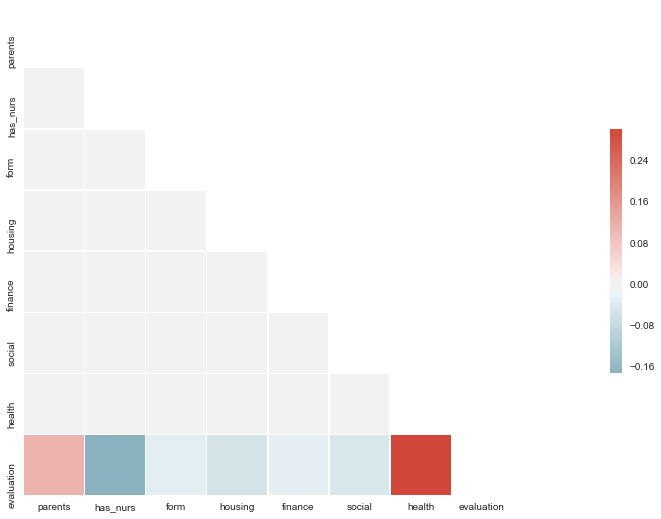

In [18]:

sns.set(style="white")
# the correlation matrix
corr = nursery_data.corr()
# a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(35, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
p = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We see there is no correlation among attributes. Due could be the fact we work with artificially aggregated data 
basing on applications. However all attributes relate to the target variable. Highest correlations are witnessed 
by the health conditions of the family, followed by he parents occupation and if parents have nursing experience. 
We see also that the dataset is noiseless. It completely covers the attribute space.

In [19]:
corr

parents  has_nurs      form   housing   finance    social  \
parents     1.000000  0.000134  0.000127  0.000116  0.000095  0.000116   
has_nurs    0.000134  1.000000 -0.000146 -0.000134 -0.000109 -0.000134   
form        0.000127 -0.000146  1.000000 -0.000127 -0.000104 -0.000127   
housing     0.000116 -0.000134 -0.000127  1.000000 -0.000095 -0.000116   
finance     0.000095 -0.000109 -0.000104 -0.000095  1.000000 -0.000095   
social      0.000116 -0.000134 -0.000127 -0.000116 -0.000095  1.000000   
health      0.000116 -0.000134 -0.000127 -0.000116 -0.000095 -0.000116   
evaluation  0.111790 -0.173960 -0.030618 -0.057019 -0.027568 -0.046539   

              health  evaluation  
parents     0.000116    0.111790  
has_nurs   -0.000134   -0.173960  
form       -0.000127   -0.030618  
housing    -0.000116   -0.057019  
finance    -0.000095   -0.027568  
social     -0.000116   -0.046539  
health      1.000000    0.756444  
evaluation  0.756444    1.000000

In [20]:
corr["evaluation"].sort_values(ascending=False)

evaluation    1.000000
health        0.756444
parents       0.111790
finance      -0.027568
form         -0.030618
social       -0.046539
housing      -0.057019
has_nurs     -0.173960
Name: evaluation, dtype: float64

#### Prepare the Data for ML

Generally most of the Machine Learning algorithms do not perform well, when the inmut numerical attributes 
have very different scales. In our data we do not have this case e.g. range from 1 to 10 000 for instance. Algorithms 
which explore distances, like SVM or k-NN, or/and seek to reduce dimentions - PCA, FA etc.,  are sensitive to feature transformation. However it will be not worked with them 
but rather just with graphic-model based classifiers, which are invariant to feature scaling. 

However we need to split the data into training and testing data sets. We use standard 70% / 30% split. This is a classification problem, so stratify the split is stratified according to the target variable - "evaluation".

In [21]:
nursery_attributes = nursery_data.drop("evaluation", axis = 1) 
nursery_target = nursery_data.evaluation

In [23]:
nursery_attributes_train, nursery_attributes_test, nursery_target_train, nursery_target_test = train_test_split(
    nursery_attributes, nursery_target, stratify=nursery_target, train_size=0.7, test_size=0.3)

 

### I. II. Supervised Classification: Naïve Bayes 

Naive Bayes models are considered as efficient, as they learn parameters by looking at each feature individually and collect simple per-class statistics from each feature. There are basically three kinds of naive classifiers implemented in python and  which we can use: `GaussianNB`, `BernoulliNB` and `MultinomialNB`. We apply the last one, as it assumes discrete count data, represented as integers. This model has a single parameter `àlpha`, which controls for the model complexity. 
    Naive Bayes calculates the posterior probability P(c|x) from P(c), P(x) and P(x|c), 

\begin{equation*}
P(c| x)   = \frac{P(x|c)P(c)}{P(x)}
\end{equation*}

where:

$P(c|x)$ is the posterior probability of class (c, target) given predictor (x, attributes). <br />
$P(c)$ is the prior probability of class. <br />
$P(x|c)$ is the likelihood which is the probability of predictor given class. <br />
$P(x)$ is the prior probability of predictor. <br />

Assumptions:
* assumption of independent predictors. In real life, it is almost impossible that we get a set of predictors which are completely independent.    
* It performs well in case of categorical input variables compared to numerical variable(s). For numerical variable, 
    normal distribution is assumed (bell curve, which is a strong assumption).  
* If categorical variable has a category (in test data set), which was not observed in training data set, then the model
    will assign a 0 (zero) probability and will be unable to make a prediction. This is often known as “Zero Frequency”.
    To solve this, we can use the smoothing technique. One of the simplest smoothing techniques is called Laplace estimation.

In [24]:
# naive bayes
bayes_clf = MultinomialNB()
bayes_clf.fit(nursery_attributes_train, nursery_target_train)
y_pred = bayes_clf.predict(nursery_attributes_test)  # store the predicted outputs

#### Accuracy  

- The model achieved an accuracy of 0.86. Therefore we can state that 86 % of new data would be correctly classified

In [25]:
accuracy_score(nursery_target_test, y_pred)

0.8626543209876543

#### Confusion Matrix
From 1296 actual individuals of the group $not\_recomment$, - Class 0,  the classifier predicted correctly 1279 of them. 

In [26]:
conf_mx = confusion_matrix(nursery_target_test, y_pred)
conf_mx

array([[1279,    0,    1,   16],
       [   0,    0,   99,    0],
       [   0,    0, 1075,  205],
       [   0,    0,  213, 1000]], dtype=int64)

<function matplotlib.pyplot.show(*args, **kw)>

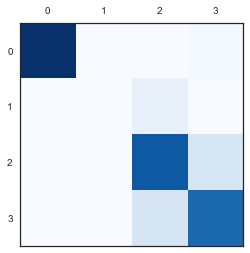

In [27]:
plt.matshow(conf_mx, cmap = plt.cm.Blues)
plt.show

#### Precision, recall, F1 score


##### Precision
It show how often the positive classifications are correct. From the table below we see the problem of predicting Class 1  
##### Recall
In our case it shows how often the actually belonging to their class individuals are predicted as such. It shows "the true positive rate"
##### F - Score
That is the mean of precision and recall

In [44]:
print(classification_report(nursery_target_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99      1296
          1       0.00      0.00      0.00        99
          2       0.77      0.84      0.81      1280
          3       0.82      0.82      0.82      1213

avg / total       0.84      0.86      0.85      3888



C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### ROC curve

Reciever Operating Characteristics

The ROC curve the true positive rate (recall) against the false positive rate. The FPR ist the ratio of the negative instances which are correctly classified as positive. The ROC curve plots sensitivity (recall) versus 1-specifity. Specifity is the True negative rate, which is the ratio of negative instances, which are correctly classified as negative. 


ROC curves are principally used in binary classification to study the output of a classifier. We have a problem of multi-class  classification. Hence the the output can be binarized and one ROC curve can be drawn per label.

We measure compare the classifiers for each class respectively by measuring the area under the curve (AUC). A perfect classifier would have a ROC AUC equal to 1 and a purely random one will show a ROC AUC of 0.5

In [29]:
nursery_target.shape

(12959,)

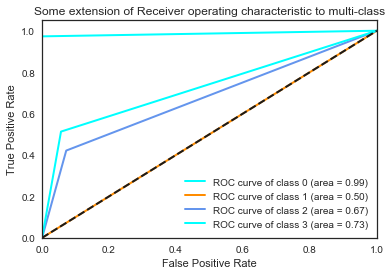

In [33]:
# classes to binary variables
nursery_target_b = label_binarize(nursery_target, classes=[0, 1, 2, 3])
n_classes = nursery_target_b.shape[1]

X_train, X_test, y_train, y_test = train_test_split(nursery_attributes, nursery_target_b, train_size=0.7, test_size=0.3)

# predict each class vs. the other
classifier = OneVsRestClassifier(MultinomialNB())
y_score = classifier.fit(X_train, y_train).predict(X_test)

# ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# in the end average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### III Tuning the models

####  Cross-Validation


To achieve better evaluation of the model we will use cross-validation. That is a random split into a number (we will choose 5) of different subsets. Those are called also folds and we will perform stratified K-fold cross validation. After the split the model is trained and evaluated, taking a different fold for evaluation every time and training on the rest 4.

The result is an array containing 5 evaluation scores.The cross-validation allows us to get not only an estimate of the model's performance and also a measure of how precise this estimate is (the standard deviation).


In [54]:
bayes_scores_scv = cross_val_score(bayes_clf, nursery_attributes_train, nursery_target_train, cv=5)

In [55]:
print("Scores:", bayes_scores_scv)
print("Mean:", bayes_scores_scv.mean())
print("Standard deviation:", bayes_scores_scv.std())

Scores: [0.87059471 0.86163175 0.85446527 0.8660419  0.854385  ]
Mean: 0.8614237260826825
Standard deviation: 0.006378739657197674


#### Leave One Out CV

LOOCV takes just one data point from the data and trains the model on the rest of it. This approach iterates for each data point. Hence:  
* All data points are considered => low bias  
* the cross validation is repeated n times (n - number of data points) which takes time and comuptational resources
* it  test against one data point => higher variation aka. low efficiency. The respective data point has high impact over the estimation.  If this data is an outlier, it can lead to a higher variation. Our Stdandard Deviation results exemplify this. 

In [52]:
loocv = LeaveOneOut()
results_loocv = cross_val_score(bayes_clf, nursery_attributes_train, nursery_target_train, cv=loocv)

In [57]:
print("Mean Score:", results_loocv.mean())
print("Standard deviation:", results_loocv.std())

Mean Score: 0.86164700694521
Standard deviation: 0.34527010059889524


#### Try Grid Search

We will optimize the hyperparameters of our models. The Grid-Search method allows us to 
specifiy the values of the hyperparamethers we want to try out. Here we evaluate all combinations using cross validation.

In [45]:
# grid search naive bayes

param_grid = [
    {'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}
]
bayes_classifier = MultinomialNB()
grid_search = GridSearchCV(bayes_classifier, param_grid, cv=5, scoring = "accuracy")
grid_search.fit(nursery_attributes_train, nursery_target_train)
best_bayes_classifier = grid_search.best_estimator_
print("Naive Bayes - best parameters:", grid_search.best_params_)
print("Naive Bayes - best score:", grid_search.best_score_)

Naive Bayes - best parameters: {'alpha': 0.1}
Naive Bayes - best score: 0.8615367655164811


In [44]:
bayes_classifier_score = best_bayes_classifier.score(nursery_attributes_test, nursery_target_test)
bayes_classifier_score

0.8665123456790124

#### IV. Correlation Structure 
In the descriptive part we saw there is no correlation among attributes. However all  relate to the target variable. Highest correlations are witnessed by the health conditions of the family, followed by he parents occupation and if parents have nursing experience. We see also that the dataset is noiseless. It completely covers the attribute space.

In [59]:
corr

parents  has_nurs      form   housing   finance    social  \
parents     1.000000  0.000134  0.000127  0.000116  0.000095  0.000116   
has_nurs    0.000134  1.000000 -0.000146 -0.000134 -0.000109 -0.000134   
form        0.000127 -0.000146  1.000000 -0.000127 -0.000104 -0.000127   
housing     0.000116 -0.000134 -0.000127  1.000000 -0.000095 -0.000116   
finance     0.000095 -0.000109 -0.000104 -0.000095  1.000000 -0.000095   
social      0.000116 -0.000134 -0.000127 -0.000116 -0.000095  1.000000   
health      0.000116 -0.000134 -0.000127 -0.000116 -0.000095 -0.000116   
evaluation  0.111790 -0.173960 -0.030618 -0.057019 -0.027568 -0.046539   

              health  evaluation  
parents     0.000116    0.111790  
has_nurs   -0.000134   -0.173960  
form       -0.000127   -0.030618  
housing    -0.000116   -0.057019  
finance    -0.000095   -0.027568  
social     -0.000116   -0.046539  
health      1.000000    0.756444  
evaluation  0.756444    1.000000

### 6.3 Supervised Classification: k-nearest Neighbors
I. Analyze the same dataset as before using the k-nearest Neighbor approach.  
II. Determine the best value for k using cross-validation.  
III. Discuss the same properties as before for this method, for the best k.  
IV. Use the same 3 hold-out set strategies as before.  
V. Describe a data-structure that could be used in the actual implementation of the algorithm to
speed-up the distance calculations. Explain which speed-up can be achieved on average.  

#### I. Analyze the same dataset. Accuracy

In [38]:
knn_clf = KNeighborsClassifier(n_neighbors=5)     # default is 5
knn_clf.fit(nursery_attributes_train, nursery_target_train)
y_pred_knn = knn_clf.predict(nursery_attributes_test)

print("Accuracy:", accuracy_score(nursery_target_test, y_pred_knn))

Accuracy: 0.9665637860082305


#### II., III.  Cross validation to find the best value for K

In [39]:
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
knn_cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, nursery_attributes_train, nursery_target_train, cv=5, scoring='accuracy')
    knn_cv_scores.append(scores.mean())

To analyze which is the best value for K, we  plot the misclassification error versus K. The model achieves its highest accuracy when K = 6, 7 or 8

In [40]:
mse = [1 - x for x in knn_cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel('N K-Neighbors')
plt.ylabel('Misclassification Error')
plt.show()

The optimal number of neighbors is 7


#### Confusion Matrix, Precision, recall, F1 score


In [41]:
conf_mx_knn = confusion_matrix(nursery_target_test, y_pred_knn)
conf_mx_knn

array([[1296,    0,    0,    0],
       [   0,   72,   27,    0],
       [   0,    0, 1224,   56],
       [   0,    0,   47, 1166]], dtype=int64)

In [42]:
print(classification_report(nursery_target_test, y_pred_knn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1296
          1       1.00      0.73      0.84        99
          2       0.94      0.96      0.95      1280
          3       0.95      0.96      0.96      1213

avg / total       0.97      0.97      0.97      3888



Up to know we witness a better performance of the KNN Classifier on this data set. This is especially visibale from the much better classification of our unbalanced Class 1. The same evident we see at the combined ROC curve for the KNN classification of each class separately. We show this below. Both multiclass classificators Naive Bayes and KNN could be plotted into a single plot. However this will overwhelm the graph, so I will abstain if doing this.

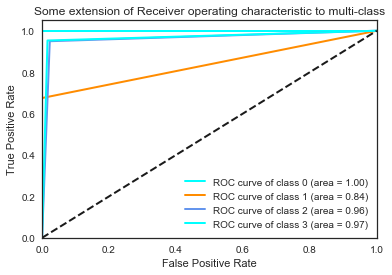

In [35]:
# predict each class vs. the other
classifier= OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
y_score= classifier.fit(X_train, y_train).predict(X_test)

# ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr_k)
for i in range(n_classes):
    mean_tpr += interp(all_fpr_k, fpr[i], tpr[i])

# in the end average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

#### V. Discussion and KNN Specifics (speed, complexity)

The KNN classifier is not just a simple and easy to implement algorithm. It has very short running time and that makes it attractive when compared to more complex algorithms. It is suitable for multiclass classification whereas other algorithms are developed primary for binary dependent variables. This was exemplified also in the current projekt, where KNNs outperformed the Naive Bayes Classifier. Further, it is a non-parametric algorithm and in this sense it is appropriate to be applied at complex data sets.  
On the other hand, KNN has a computationally tedious testing phase. This makes it unatractive to be applied in production. For instance Deep Learning methods have long training but zero testing phase. Data of higher dimensions is problematic for this algorithm, because in that case, the difference between the nearest and farthest neighbour is low.    
We can decrease the testing time by apllying approximate Nearest Neighbor techniques such as using K-D trees, metric trees,  or ball-tree to store the training observations. However  these methods  perform poorly in high dimensions.  
